In [37]:
# source activate gensim_py36
# Refer: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [3]:
import sys
print(sys.prefix)

/Users/kavitakanojiya/anaconda2/envs/gensim_py36


In [4]:
# !pip install spacy
# !pip install pyLDAvis
# !pip install nltk
# !pip install seaborn
# !pip install wordcloud
# python -m spacy download en

In [5]:
# Load libraries #

import csv
import json

import re
import numpy
import pandas
from pprint import pprint
import seaborn as sns

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as pyplot
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

/Users/kavitakanojiya/anaconda2/envs/gensim_py36/lib/python3.6/site-packages/spacy/util.py:6: UserWarning: Module gensim was already imported from /Users/kavitakanojiya/anaconda2/envs/gensim_py36/lib/python3.6/site-packages/gensim/__init__.py, but /Users/kavitakanojiya/Desktop/PL/capstone-machine-learning is being added to sys.path
  import pkg_resources


In [6]:
# Load all data #

authored_contents = pandas.read_csv("./author detection datasets/train.csv")

unauthored_contents = pandas.read_csv("./author detection datasets/test.csv")

In [7]:
authored_contents.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
unauthored_contents.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [9]:
authored_contents.shape

(19579, 3)

In [10]:
training_records = len(authored_contents)

author_eap, author_mws, author_hpl = authored_contents.author.value_counts()

print("Total number of authored contents: ", training_records)
print("Total number of authored contents by EAP: ", author_eap)
print("Total number of authored contents by MWS: ", author_mws)
print("Total number of authored contents by HPL: ", author_hpl)

Total number of authored contents:  19579
Total number of authored contents by EAP:  7900
Total number of authored contents by MWS:  6044
Total number of authored contents by HPL:  5635


In [11]:
# grab text length of each contents

authored_contents['text_length'] = authored_contents['text'].str.len()

In [12]:
authored_contents.head()

,id,text,author,text_length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


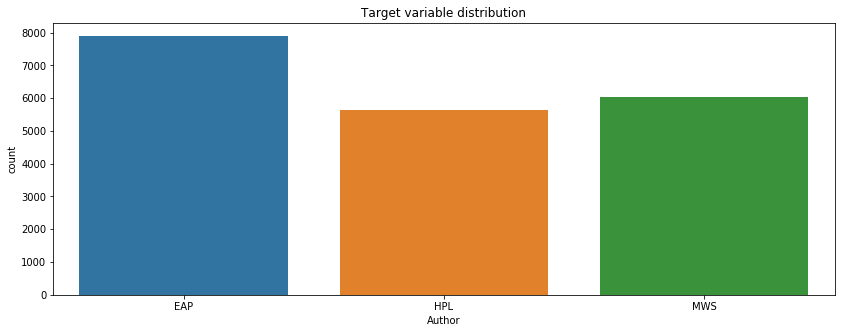

In [13]:
pyplot.figure(figsize=(14,5))
sns.countplot(authored_contents['author'],)
pyplot.xlabel('Author')
pyplot.title('Target variable distribution')
pyplot.show()

In [14]:
authored_contents.groupby('author').size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

In [15]:
# examine the same in test data

testing_records = len(unauthored_contents)

unauthored_contents['text_length'] = unauthored_contents['text'].str.len()

In [16]:
unauthored_contents.head()

,id,text,text_length
0,id02310,"Still, as I urged our leaving Ireland with suc...",110
1,id24541,"If a fire wanted fanning, it could readily be ...",330
2,id00134,And when they had broken down the frail door t...,189
3,id27757,While I was thinking how I should possibly man...,223
4,id04081,I am not sure to what limit his knowledge may ...,53


In [17]:
def text_len(df):
    df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))
    df['num_uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['num_chars'] = df['text'].apply(lambda x: len(str(x)))
    df['num_stopwords'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                          if w in set(stopwords.words('english'))]))
    df['num_punctuations'] = df['text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
    df['num_words_upper'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['num_words_title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['mean_word_len'] = df['text'].apply(lambda x: numpy.mean([len(w) for w in str(x).split()]))
    df['num_character_len'] = df['text'].apply(lambda x: len(x))

In [18]:
text_len(authored_contents)
text_len(unauthored_contents)

In [19]:
def plot_heatmap(df):
    pyplot.figure(figsize=(14,6))

    pyplot.subplot(211)
    sns.heatmap(pandas.crosstab(df['author'], df['num_words']), cmap='gist_earth', xticklabels=True)
    pyplot.xlabel('Original text word count')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['num_uniq_words']), cmap='gist_heat', xticklabels=True)
    pyplot.xlabel('Unique text word count')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['num_punctuations']), cmap='gist_heat', xticklabels=True)
    pyplot.xlabel('Punctuations')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['mean_word_len']), cmap='gist_heat', xticklabels=False)
    pyplot.xlabel('Mean word length')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()

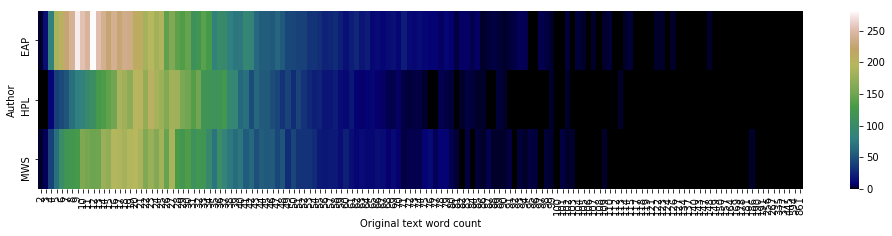

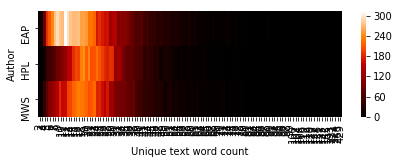

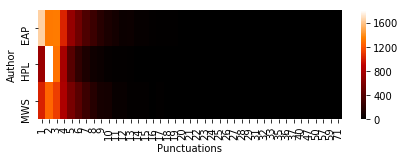

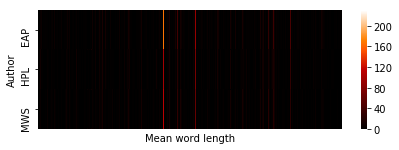

In [20]:
plot_heatmap(authored_contents)

In [22]:
eap_documents = authored_contents[authored_contents.author == 'EAP']['text'].values
hpl_documents = authored_contents[authored_contents.author == 'HPL']['text'].values
mws_documents = authored_contents[authored_contents.author == 'MWS']['text'].values

In [23]:
eap_words = " ".join(eap_documents)
hpl_words = " ".join(hpl_documents)
mws_words = " ".join(mws_documents)

In [24]:
from wordcloud import WordCloud, STOPWORDS

In [25]:
stop_words_list = stopwords.words('english')
stop_words_list.extend(['might', 'us'])

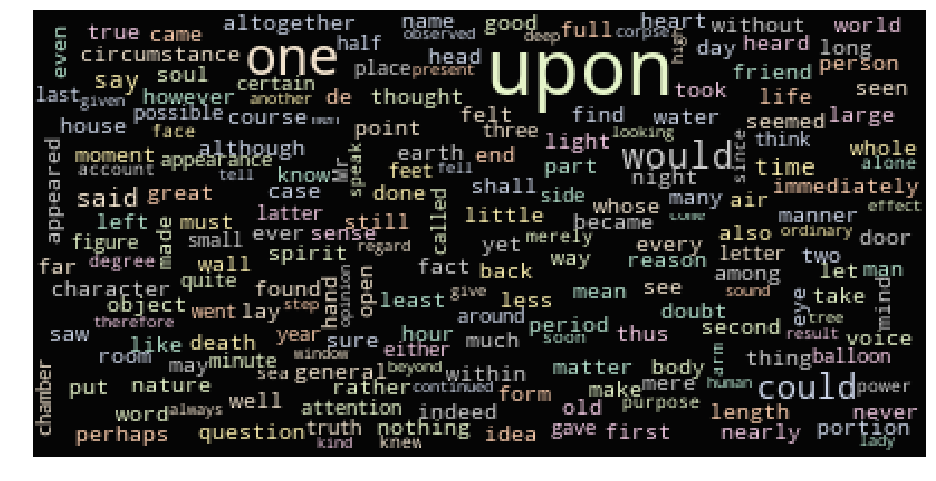

In [26]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = stop_words_list, max_font_size= 35)
wordcloud.generate(eap_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

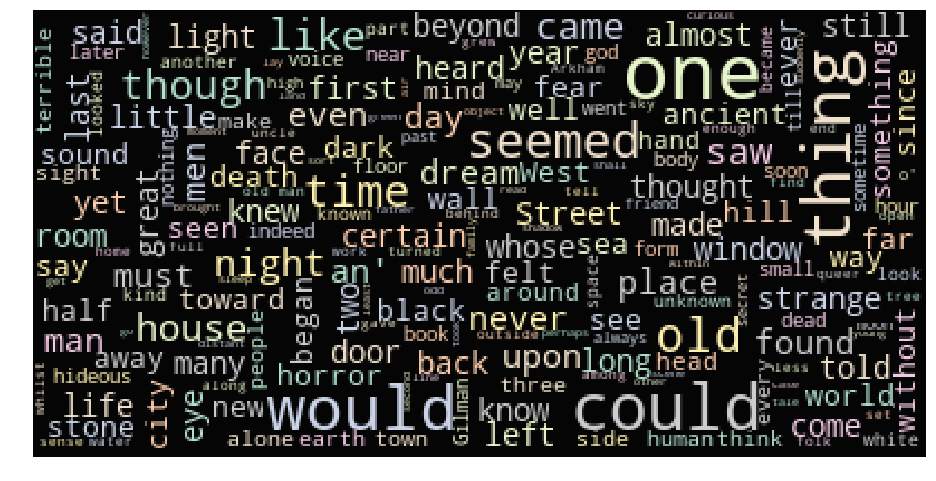

In [27]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = stop_words_list, max_font_size= 35)
wordcloud.generate(hpl_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

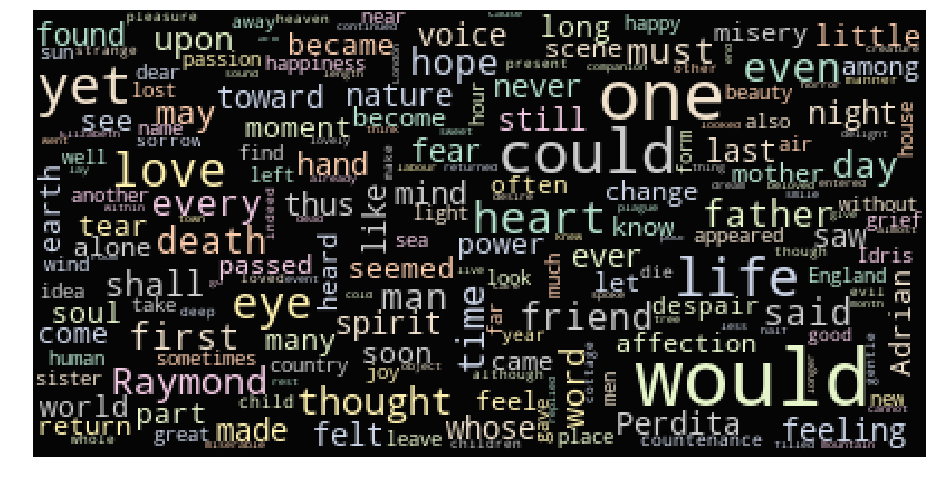

In [28]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = stop_words_list, max_font_size= 35)
wordcloud.generate(mws_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

In [29]:
authored_contents['numerical_author'] = authored_contents.author.map({ 'EAP': 0, 'HPL': 1, 'MWS': 2 })

In [30]:
# Quick view of preprocessing

authored_contents[['text', 'author', 'numerical_author']].head()

,text,author,numerical_author
0,"This process, however, afforded me no means of...",EAP,0
1,It never once occurred to me that the fumbling...,HPL,1
2,"In his left hand was a gold snuff box, from wh...",EAP,0
3,How lovely is spring As we looked from Windsor...,MWS,2
4,"Finding nothing else, not even gold, the Super...",HPL,1


In [31]:
authored_contents.head()

,id,text,author,text_length,num_words,num_uniq_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,num_character_len,numerical_author
0,id26305,"This process, however, afforded me no means of...",EAP,231,41,35,231,19,7,2,3,4.658537,231,0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,14,14,71,8,1,0,1,4.142857,71,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,36,32,200,16,5,0,1,4.583333,200,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,34,32,206,13,4,0,4,5.088235,206,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,27,25,174,11,4,0,2,5.481481,174,1


In [32]:
data = authored_contents['text']

# remove emails
data = [re.sub('\S*@\S*\s', '', sent) for sent in data]

# remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# remove single quotes
data = [re.sub("\'", '', sent) for sent in data]

# pprint(data)

In [33]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(data))
pprint(data_words[:1])

[['this',
  'process',
  'however',
  'afforded',
  'me',
  'no',
  'means',
  'of',
  'ascertaining',
  'the',
  'dimensions',
  'of',
  'my',
  'dungeon',
  'as',
  'might',
  'make',
  'its',
  'circuit',
  'and',
  'return',
  'to',
  'the',
  'point',
  'whence',
  'set',
  'out',
  'without',
  'being',
  'aware',
  'of',
  'the',
  'fact',
  'so',
  'perfectly',
  'uniform',
  'seemed',
  'the',
  'wall']]


In [34]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

/Users/kavitakanojiya/anaconda2/envs/gensim_py36/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['this', 'process', 'however', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', 'as', 'might', 'make', 'its', 'circuit', 'and', 'return', 'to', 'the', 'point', 'whence', 'set', 'out', 'without', 'being', 'aware', 'of', 'the', 'fact', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall']


In [35]:
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words_list] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [36]:
data_words_nostops = remove_stopwords(data_words)

data_word_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable = ['parser', 'ner'])

data_lemmatized = lemmatization(data_word_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['process', 'however', 'afford', 'mean', 'ascertain', 'dimension', 'dungeon', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'aware', 'fact', 'perfectly', 'uniform', 'seem', 'wall']]


In [38]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [39]:
# id2word[0]

'afford'

In [42]:
data_lemmatized[0]

['process',
 'however',
 'afford',
 'mean',
 'ascertain',
 'dimension',
 'dungeon',
 'make',
 'circuit',
 'return',
 'point',
 'whence',
 'set',
 'aware',
 'fact',
 'perfectly',
 'uniform',
 'seem',
 'wall']

In [43]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('afford', 1),
  ('ascertain', 1),
  ('aware', 1),
  ('circuit', 1),
  ('dimension', 1),
  ('dungeon', 1),
  ('fact', 1),
  ('however', 1),
  ('make', 1),
  ('mean', 1),
  ('perfectly', 1),
  ('point', 1),
  ('process', 1),
  ('return', 1),
  ('seem', 1),
  ('set', 1),
  ('uniform', 1),
  ('wall', 1),
  ('whence', 1)]]

In [57]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=20,
                                           update_every=1,
                                           chunksize=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [56]:
pprint(lda_model.print_topics())

[(0,
  '0.012*"man" + 0.012*"time" + 0.009*"long" + 0.009*"day" + 0.009*"old" + '
  '0.009*"great" + 0.008*"life" + 0.008*"hear" + 0.008*"good" + 0.008*"take"'),
 (1,
  '0.016*"could" + 0.016*"come" + 0.013*"say" + 0.013*"see" + 0.011*"know" + '
  '0.011*"make" + 0.009*"find" + 0.008*"not" + 0.008*"tell" + 0.008*"go"'),
 (2,
  '0.011*"may" + 0.011*"never" + 0.009*"would" + 0.009*"feel" + 0.008*"love" + '
  '0.008*"house" + 0.007*"look" + 0.007*"think" + 0.006*"idea" + '
  '0.006*"dream"')]


In [47]:
doc_lda = lda_model[corpus]

In [49]:
print("\nPerplexity: ", lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.920170056015664

Coherence Score:  0.35608586649023016


In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/kavitakanojiya/anaconda2/envs/gensim_py36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.290094  0.145930       1        1  7.816360
18     0.107156 -0.105390       2        1  6.180232
0      0.076143 -0.270916       3        1  6.065566
19     0.038891 -0.001782       4        1  5.901814
1     -0.029387 -0.014630       5        1  5.844662
3     -0.011775  0.007397       6        1  5.828584
4      0.002920 -0.021546       7        1  5.589400
17    -0.015680 -0.015610       8        1  5.438582
2     -0.026171  0.002945       9        1  5.182126
11    -0.032947  0.026015      10        1  4.917631
16    -0.041639  0.027170      11        1  4.847549
6     -0.039360  0.043142      12        1  4.829243
14    -0.037635  0.023313      13        1  4.662639
7     -0.046552  0.029276      14        1  4.649984
12    -0.044254  0.017220      15        1  4.162823
9     -0.042805  0.017893      16        1  4.139527
13    -0.039751  0.022062      17        1  4.044802
8     -0.019965  0.020754      18        1  3.865061
10    -0.040682  0.022781      19        1  3.235951
15    -0.046603  0.023975      20        1  2.797466, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
134    Default  1330.000000       could  1330.000000  30.0000  30.0000
583    Default  1148.000000         see  1148.000000  29.0000  29.0000
219    Default  1404.000000        come  1404.000000  28.0000  28.0000
152    Default  1168.000000         say  1168.000000  27.0000  27.0000
141    Default  1008.000000        know  1008.000000  26.0000  26.0000
339    Default   949.000000         man   949.000000  25.0000  25.0000
8      Default   955.000000        make   955.000000  24.0000  24.0000
266    Default   831.000000        time   831.000000  23.0000  23.0000
22     Default   863.000000       never   863.000000  22.0000  22.0000
1032   Default   880.000000         may   880.000000  21.0000  21.0000
257    Default   903.000000          go   903.000000  20.0000  20.0000
66     Default   835.000000        find   835.000000  19.0000  19.0000
437    Default   731.000000         old   731.000000  18.0000  18.0000
73     Default   790.000000       think   790.000000  17.0000  17.0000
31     Default   697.000000        hand   697.000000  16.0000  16.0000
1495   Default   868.000000       voice   868.000000  15.0000  15.0000
183    Default   667.000000        life   667.000000  14.0000  14.0000
91     Default   663.000000        hear   663.000000  13.0000  13.0000
89     Default   658.000000        good   658.000000  12.0000  12.0000
84     Default   678.000000        feel   678.000000  11.0000  11.0000
144    Default   708.000000        long   708.000000  10.0000  10.0000
96     Default   686.000000         not   686.000000   9.0000   9.0000
30     Default   680.000000       great   680.000000   8.0000   8.0000
172    Default   698.000000         day   698.000000   7.0000   7.0000
242    Default   644.000000        love   644.000000   6.0000   6.0000
160    Default   669.000000       would   669.000000   5.0000   5.0000
601    Default   720.000000        tell   720.000000   4.0000   4.0000
65     Default   657.000000        even   657.000000   3.0000   3.0000
50     Default   588.000000        look   588.000000   2.0000   2.0000
585    Default   548.000000       still   548.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
761    Topic20    49.386612        fire    50.307610   3.5580  -4.9137
1328   Topic20    39.105358      weight    40.026352   3.5532  -5.1471
875    Topic20    23.916502     courage    24.837498   3.5387  -5.6388
1893   Topic20    17.955883      assure    18.876879   3.5264  -5.9255
3620   Topic20    11.694983       fiend    12.616217   3.5006  -6.3542
3822   Topic20     7.534456        rule     8.455524   3.4611  -6.7939
1052   Topic20     5.7

In [52]:
# df = pandas.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [53]:
# print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [54]:
# len(df.target_names.unique())

20